## **Malaria Detection using  a deep CNN with Dropout + proper weight initialization + Zero Padding**

Team: Malar-ai.netlify.app

Biomedical Engineering
Addis Ababa Institute of Technology
Addis Ababa University

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrahamgenetu","key":"0da3b16e3c3e59eb21cfb2b295b55b38"}'}

In [ ]:
!ls -lha kaggle.json

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 69 May 23 11:37 kaggle.json


In [ ]:
!kaggle datasets list -s malaria


ref                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
imdevskp/malaria-dataset                            Malaria Dataset                                      52KB  2020-07-01 17:28:22           5524         87  1.0              
iarunava/cell-images-for-detecting-malaria          Malaria Cell Images Dataset                         675MB  2018-12-05 05:40:21          43414       1180  0.625            
kmader/malaria-bounding-boxes                       Malaria Bounding Boxes                                4GB  2019-05-09 13:37:54           3481        118  0.75             
miracle9to9/files1                                  Malaria Dataset                                     525MB  2020-01-0

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria  --force

 97% 654M/675M [00:06<00:00, 132MB/s]
100% 675M/675M [00:06<00:00, 104MB/s]


In [ ]:
!unzip malaria-detection-dataset.zip -d malaria-detection-dataset

Streaming output truncated to the last 5000 lines.
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png

### **Importing Libraries**

In [ ]:
# set seeds to ensure repeatability of results
import pandas as pd
import numpy as np
import os
import cv2
from numpy.random import seed
import tensorflow
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import itertools
import shutil
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import binary_accuracy

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define the height and width of the images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

# Specify the number of images to be held out for validation
NUM_HOLDOUT_IMAGES = 200

# Set the number of epochs to train the model for and the number of folds
NUM_EPOCHS = 20
NUM_FOLDS = 5

# Define the amount of padding to add to the images and the batch size
PADDING = 10
BATCH_SIZE = 10

# Set the number of epochs to train the final model for
NUM_FINAL_MODEL_EPOCHS = 10

In [ ]:

#
path_uninfected = 'malaria-detection-dataset/cell_images/Uninfected/'
path_parasitized = 'malaria-detection-dataset/cell_images/Parasitized/'

uninfected_list = os.listdir(path_uninfected)
parasitized_list = os.listdir(path_parasitized)

print('Uninfected: ', len(uninfected_list))
print('Parasitized: ', len(parasitized_list))

Uninfected:  13780
Parasitized:  13780


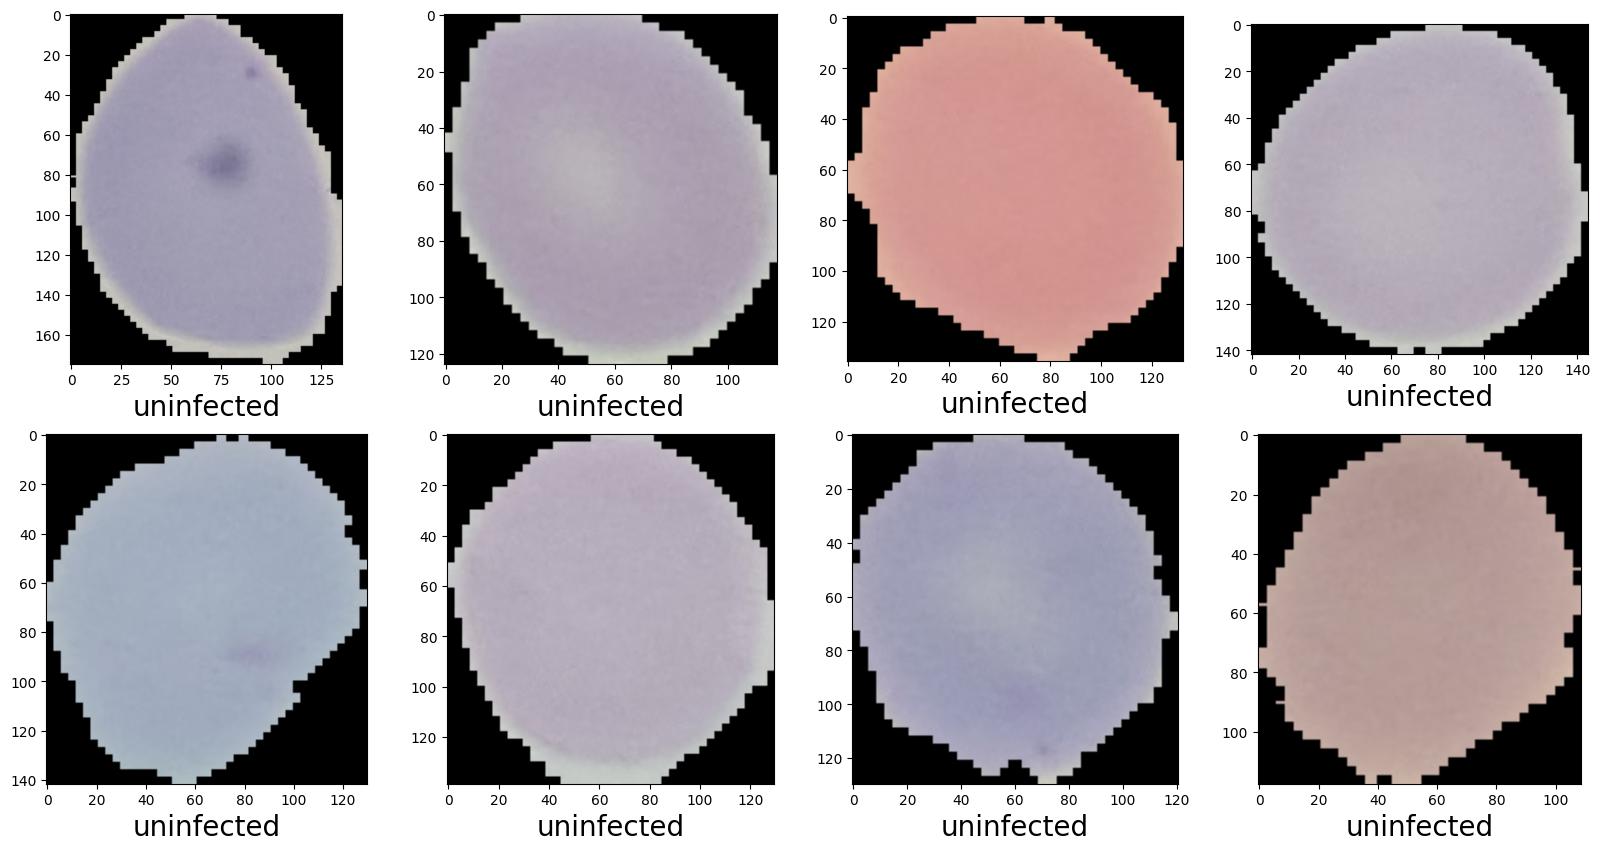

In [ ]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(20,10))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image from the uninfected list
    image = uninfected_list[i]

    # Read the image file from the uninfected folder and convert it to an array
    img_array = plt.imread(path_uninfected + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'uninfected' with a font size of 20
    plt.xlabel('uninfected', fontsize=20)

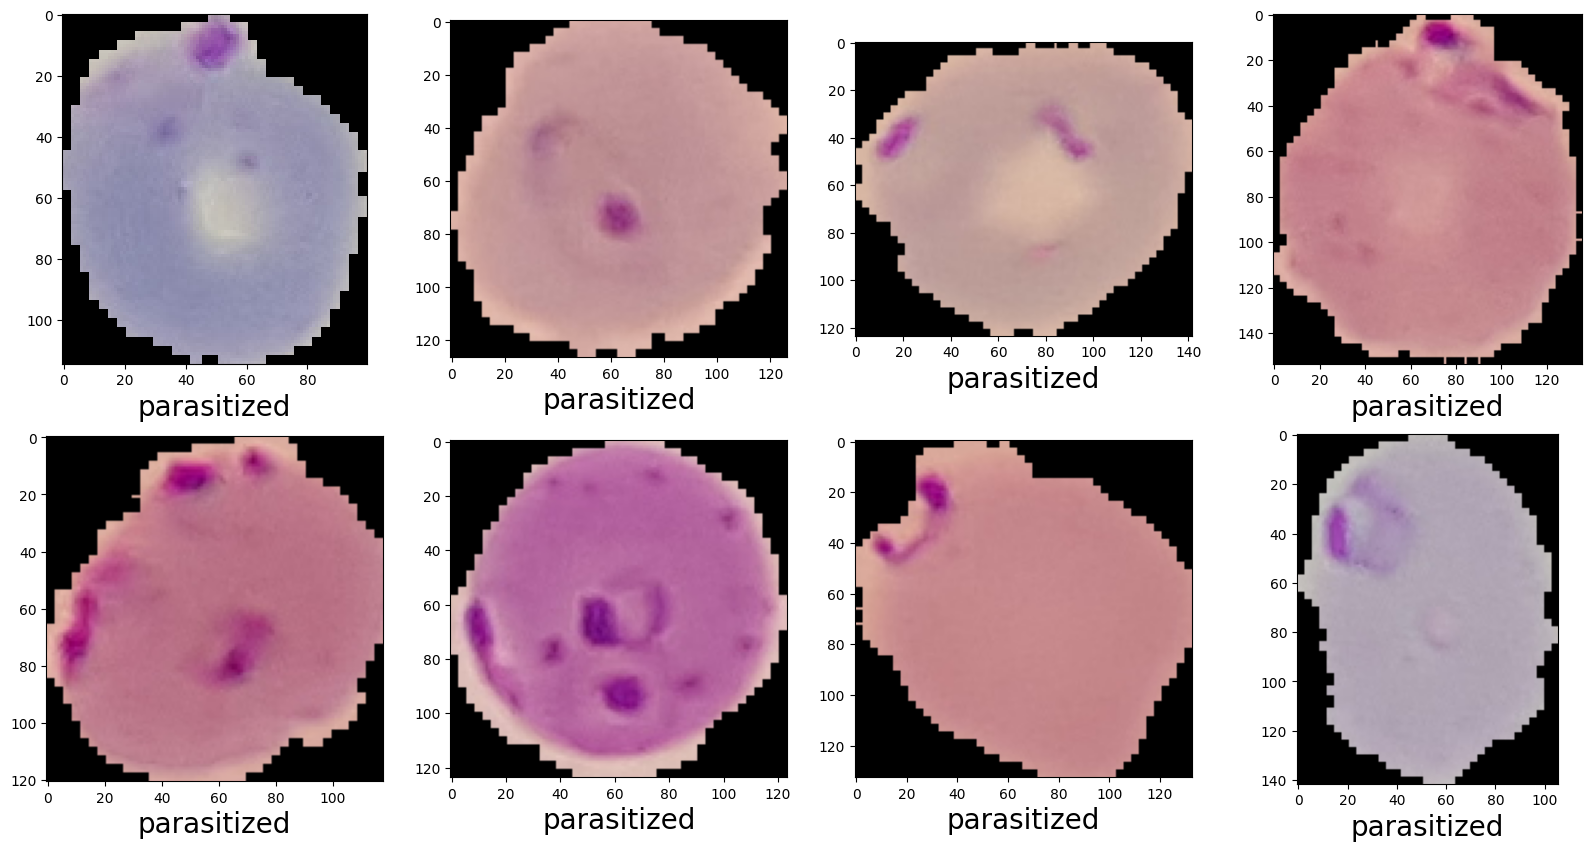

In [ ]:
# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image = parasitized_list[i]

    # display the image
    plt.imshow(plt.imread(path_parasitized + image))

    plt.xlabel('parasitized', fontsize=20)

In [ ]:
# Check if any non image files are present in the folder

# Check if any non image files are present in the folder

for item in parasitized_list:
    # split the filename into a list
    file_list = item.split('.')

    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Parasitized folder: ',item)

for item in uninfected_list:
    # split the filename into a list
    file_list = item.split('.')

    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Uninfected folder: ', item)

Parasitized folder:  Thumbs.db
Uninfected folder:  Thumbs.db


### **Put the image names into dataframes**
Here we will create a dataframe called df_combined that includes both uninfected and parasitized images. This new dataframe will have a column showing the target class of each image.

In [ ]:
# create the dataframe
df_uninfected = pd.DataFrame(uninfected_list, columns=['image_id'])
# remove the non image file
df_uninfected = df_uninfected[df_uninfected['image_id'] != 'Thumbs.db']
# add a target column
df_uninfected['target'] = 0

# create the dataframe
df_parasitized = pd.DataFrame(parasitized_list, columns=['image_id'])
# remove the non image file
df_parasitized = df_parasitized[df_parasitized['image_id'] != 'Thumbs.db']
# add a target column
df_parasitized['target'] = 1

print(df_uninfected.shape)
print(df_parasitized.shape)
# Combine the two dataframes
df_combined = pd.concat([df_uninfected, df_parasitized], axis=0).reset_index(drop=True)
df_combined.shape

(13779, 2)
(13779, 2)


(27558, 2)

In [ ]:
# Check if the image names are unique.
# The output should be 27558

df_combined['image_id'].nunique()

27558

In [ ]:
df_combined.head()

,image_id,target
0,C91P52ThinF_IMG_20150821_124739_cell_76.png,0
1,C184P145ThinF_IMG_20151203_103114_cell_57.png,0
2,C220ThinF_IMG_20151106_154016_cell_44.png,0
3,C97P58ThinF_IMG_20150917_145555_cell_74.png,0
4,C237ThinF_IMG_20151127_105320_cell_220.png,0


### **What are the image sizes and how many channels does each have?**
Here we will add the following info on each image to the df_combined dataframe:

w = width,
h = height,
c = number of channels,
max_pixel_value,
min_pixel_value,
image_format,

In [ ]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """

    if file_name in uninfected_list:

        path = path_uninfected

    else:
        path = path_parasitized


    image = cv2.imread(path + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    img_format = file_name.split('.')[1]
    output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val, img_format]
    return output

m = np.stack(df_combined['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val', 'image_format'])

df_combined = pd.concat([df_combined,df],axis=1, sort=False)

df_combined.head(10)

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
0,C91P52ThinF_IMG_20150821_124739_cell_76.png,0,157,106,3,225,0,png
1,C184P145ThinF_IMG_20151203_103114_cell_57.png,0,175,136,3,204,0,png
2,C220ThinF_IMG_20151106_154016_cell_44.png,0,124,118,3,213,0,png
3,C97P58ThinF_IMG_20150917_145555_cell_74.png,0,136,133,3,227,0,png
4,C237ThinF_IMG_20151127_105320_cell_220.png,0,142,145,3,207,0,png
5,C181P142ThinF_IMG_20151127_155914_cell_128.png,0,142,130,3,200,0,png
6,C203ThinF_IMG_20151029_102123_cell_126.png,0,139,130,3,210,0,png
7,C145P106ThinF_IMG_20151016_154756_cell_31.png,0,130,121,3,203,0,png
8,C50P11thinF_IMG_20150724_120553_cell_127.png,0,118,109,3,214,0,png
9,C87P48ThinF_IMG_20150820_144714_cell_146.png,0,154,148,3,220,0,png


In [ ]:
# Check if all images have 3 channels
df_combined['c'].value_counts()

3    27558
Name: c, dtype: int64

In [ ]:
# Check if all images are in png format
df_combined['image_format'].value_counts()

png    27558
Name: image_format, dtype: int64

In [ ]:
df_combined = shuffle(df_combined, random_state=101)

# create a holdout set with 200 samples
df_holdout = df_combined.sample(NUM_HOLDOUT_IMAGES, random_state=101)

# create a list of holdout images
holdout_images_list = list(df_holdout['image_id'])


# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]

In [ ]:
df_holdout.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
6993,C46P7ThinF_IMG_20151130_205756_cell_115.png,0,157,112,3,196,0,png
905,C95P56ThinF_IMG_20150821_171530_cell_4.png,0,109,112,3,221,0,png
8,C50P11thinF_IMG_20150724_120553_cell_127.png,0,118,109,3,214,0,png
14324,C109P70ThinF_IMG_20150930_102716_cell_186.png,1,124,121,3,220,0,png
16774,C99P60ThinF_IMG_20150918_141314_cell_101.png,1,97,124,3,231,0,png


In [ ]:
# Check the shapes.
# The ouput should be:
# (200, 8)
# (27358, 8)

print(df_holdout.shape)
print(df_data.shape)

(200, 8)
(27358, 8)


In [ ]:
# Check the target distribution in the holdout set.
# 0 = uninfected
# 1 = parasitized

df_holdout['target'].value_counts()

1    105
0     95
Name: target, dtype: int64

# **Train-Test-Split Model**
Train-test-split is not the ideal way to assess model perfromance. However, it's a good starting point because it's simple to set up and runs 5 times faster than 5 fold cross validation. This helps us to:

In [ ]:
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)

In [ ]:
# check if base_dir has been created
!ls

base_dir     malaria_dataset.zip	malaria-detection-dataset.zip
kaggle.json  malaria-detection-dataset	sample_data


In [ ]:
# see what's inside base_dir
os.listdir('base_dir')

['train_dir', 'val_dir']

### **Create the Train and Val Sets**
We will create a stratified val set. This means that the val set will have the same target distribution as the train set. Actually doing stratification isn't essential here because the target is balanced. Because of this there's a good chance that randomly selecting rows will still result in the val set having a fairly balanced target distribution. Stratification is more applicable for data where the target is unbalanced.

In [ ]:
# select the column that we will use for stratification
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(23254, 8)
(4104, 8)


In [ ]:
# Check the target distribution of the val set.
# The target should be approx balanced.

df_val['target'].value_counts()

0    2053
1    2051
Name: target, dtype: int64

In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
df_data.head()

,target,w,h,c,max_pixel_val,min_pixel_val,image_format
image_id,,,,,,,
C164P125ThinF_IMG_20151116_120135_cell_39.png,0,109,106,3,191,0,png
C82P43ThinF_IMG_20150817_123500_cell_242.png,1,184,139,3,223,0,png
C181P142ThinF_IMG_20151127_160434_cell_163.png,1,130,130,3,207,0,png
C137P98ThinF_IMG_20151005_161306_cell_14.png,1,91,70,3,212,0,png
C39P4thinF_original_IMG_20150622_110435_cell_116.png,1,139,142,3,220,0,png


In [ ]:
path_uninfected = 'malaria-detection-dataset/cell_images/Uninfected/'
path_parasitized = 'malaria-detection-dataset/cell_images/Parasitized/'

# Get a list of images in each of the two folders
folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image
    target = df_data.loc[image,'target']

    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'

    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)



# Transfer the val images

for image in val_list:

    fname = image
    target = df_data.loc[image,'target']


    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'


    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst

In [ ]:
# Print the number of images in each folder

# train
print(len(os.listdir('base_dir/train_dir/a_uninfected')))
print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
print(len(os.listdir('base_dir/val_dir/a_uninfected')))
print(len(os.listdir('base_dir/val_dir/b_parasitized/')))

11631
11623
2053
2051


In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Note that here we are normalizing the images inside the generator.
# If you wanted to add some data augmentation you could do it here.
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 23254 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.


## **Create the Model Architecture**
I found this cnn architecture a while ago in a kernel created by @fmarazzi. I've since used this on several projects. It really is a good multi-purpose architecture. Here I've modified it slightly by adding a ZeroPadding layer. Later, in the error analysis section, I'll explain why I added this layer.

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 zero_padding2d (ZeroPadding  (None, 114, 114, 32)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 55, 55, 32)        0

In [ ]:
model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
filepath = "malaria_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')


callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=NUM_EPOCHS, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/20
2325/2326 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8727

2326/2326 [==============================] - 66s 24ms/step - loss: 0.2826 - accuracy: 0.8728 - val_loss: 0.1471 - val_accuracy: 0.9586
Epoch 2/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9528

2326/2326 [==============================] - 55s 24ms/step - loss: 0.1539 - accuracy: 0.9528 - val_loss: 0.1476 - val_accuracy: 0.9527
Epoch 3/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9539

2326/2326 [==============================] - 57s 24ms/step - loss: 0.1445 - accuracy: 0.9539 - val_loss: 0.1508 - val_accuracy: 0.9518
Epoch 4/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9566

2326/2326 [==============================] - 57s 25ms/step - loss: 0.1363 - accuracy: 0.9566 - val_loss: 0.1236 - val_accuracy: 0.9630
Epoch 5/20
2325/2326 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9585

2326/2326 [==============================] - 55s 24ms/step - loss: 0.1287 - accuracy: 0.9585 - val_loss: 0.1189 - val_accuracy: 0.9630
Epoch 6/20
2325/2326 [============================>.] - ETA: 0s - loss: 0.1235 - accuracy: 0.9594

2326/2326 [==============================] - 57s 24ms/step - loss: 0.1235 - accuracy: 0.9594 - val_loss: 0.1198 - val_accuracy: 0.9605
Epoch 7/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.1169 - accuracy: 0.9608

2326/2326 [==============================] - 57s 24ms/step - loss: 0.1170 - accuracy: 0.9608 - val_loss: 0.1186 - val_accuracy: 0.9649
Epoch 8/20
2325/2326 [============================>.] - ETA: 0s - loss: 0.1128 - accuracy: 0.9620

2326/2326 [==============================] - 56s 24ms/step - loss: 0.1128 - accuracy: 0.9620 - val_loss: 0.1259 - val_accuracy: 0.9588
Epoch 9/20
2326/2326 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9632

2326/2326 [==============================] - 55s 24ms/step - loss: 0.1070 - accuracy: 0.9632 - val_loss: 0.1153 - val_accuracy: 0.9654
Epoch 10/20
2326/2326 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9642

2326/2326 [==============================] - 55s 24ms/step - loss: 0.1055 - accuracy: 0.9642 - val_loss: 0.0989 - val_accuracy: 0.9669
Epoch 11/20
2325/2326 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9659

2326/2326 [==============================] - 56s 24ms/step - loss: 0.1020 - accuracy: 0.9659 - val_loss: 0.1011 - val_accuracy: 0.9649
Epoch 12/20
2325/2326 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.9655

2326/2326 [==============================] - 55s 24ms/step - loss: 0.0978 - accuracy: 0.9655 - val_loss: 0.0996 - val_accuracy: 0.9664
Epoch 13/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9680

2326/2326 [==============================] - 56s 24ms/step - loss: 0.0933 - accuracy: 0.9680 - val_loss: 0.1014 - val_accuracy: 0.9673
Epoch 14/20
2326/2326 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9684

2326/2326 [==============================] - 55s 24ms/step - loss: 0.0912 - accuracy: 0.9684 - val_loss: 0.0989 - val_accuracy: 0.9676
Epoch 15/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9697

2326/2326 [==============================] - 56s 24ms/step - loss: 0.0874 - accuracy: 0.9697 - val_loss: 0.1011 - val_accuracy: 0.9673
Epoch 16/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9705

2326/2326 [==============================] - 57s 25ms/step - loss: 0.0843 - accuracy: 0.9705 - val_loss: 0.1018 - val_accuracy: 0.9695
Epoch 17/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9713

2326/2326 [==============================] - 57s 25ms/step - loss: 0.0806 - accuracy: 0.9713 - val_loss: 0.1059 - val_accuracy: 0.9708
Epoch 18/20
2326/2326 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9723

2326/2326 [==============================] - 56s 24ms/step - loss: 0.0782 - accuracy: 0.9723 - val_loss: 0.1021 - val_accuracy: 0.9678
Epoch 19/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9741

2326/2326 [==============================] - 57s 24ms/step - loss: 0.0752 - accuracy: 0.9741 - val_loss: 0.1095 - val_accuracy: 0.9688
Epoch 20/20
2324/2326 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9754

2326/2326 [==============================] - 56s 24ms/step - loss: 0.0703 - accuracy: 0.9754 - val_loss: 0.1057 - val_accuracy: 0.9703


## **Evaluate the model using the val set**

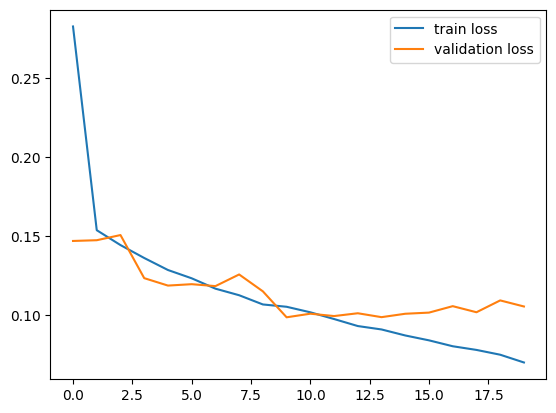

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

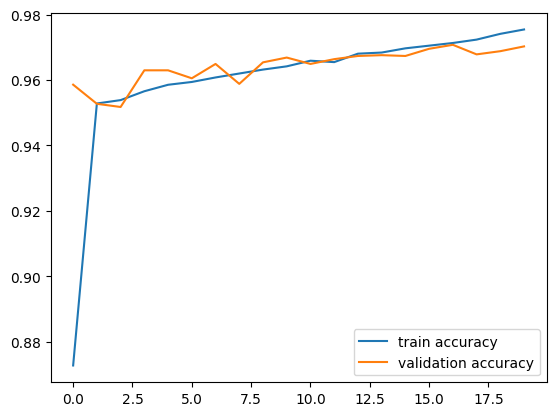

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#Saving this state of the model as h5 file
model.save('Malaria_CNN.h5')

from google.colab import files
files.download('Malaria_CNN.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [ ]:
# Here the best epoch will be used.

model.load_weights('Malaria_CNN.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen,
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.10569524765014648
val_acc: 0.9702728986740112


### **Create a Confusion Matrix**

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# Print the label associated with each class
test_gen.class_indices

{'a_uninfected': 0, 'b_parasitized': 1}

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

411/411 [==============================] - 4s 10ms/step


In [ ]:
# If you wanted to get the image_id's to match them to predictions this
# is how to do it.

test_gen.filenames

['a_uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_144104_cell_48.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145042_cell_7.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145422_cell_12.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145422_cell_21.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145609_cell_101.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_145609_cell_113.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_150041_cell_15.png',
 'a_uninfected/C100P61ThinF_IMG_20150918_150041_cell_47.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151006_cell_29.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151149_cell_32.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151335_cell_16.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151335_cell_22.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151507_cell_27.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151507_cell_48.png',
 'a_uninfected/C101P62ThinF_IMG_20150918_151942_cell_53.png',
 'a_uni

In [ ]:
# check the number of predictions
predictions.shape

(4104, 2)

In [ ]:

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(4104,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_gen.class_indices

{'a_uninfected': 0, 'b_parasitized': 1}

Confusion matrix, without normalization
[[2004   49]
 [  73 1978]]


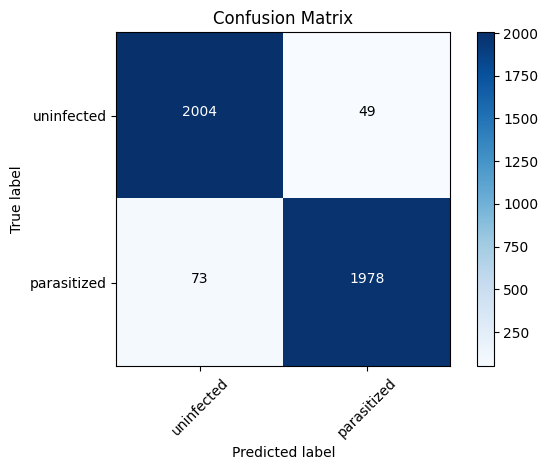

In [ ]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### **Create a Classification Report**

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

**Recall** = Given a class, will the classifier be able to detect it?

**Precision** = Given a class prediction from a classifier, how likely is it to be correct?

**F1** **Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

In [ ]:
# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

  uninfected       0.96      0.98      0.97      2053
 parasitized       0.98      0.96      0.97      2051

    accuracy                           0.97      4104
   macro avg       0.97      0.97      0.97      4104
weighted avg       0.97      0.97      0.97      4104



### **Error Analysis**

In [ ]:
# put the val image_id, labels and predictions into a dataframe

val_pred_dict = {
    'image_id': test_gen.filenames,
    'val_labels': test_gen.classes,
    'val_preds': predictions.argmax(axis=1)
}

df_val_preds = pd.DataFrame(val_pred_dict)


# Adjust the file names

# sample image name: a_uninfected/C100P61ThinF_IMG_20150918_144104_...
# we want just this part: C100P61ThinF_IMG_20150918_144104_...

def adjust_file_names(x):
    # split into a list based on '/'
    fname = x.split('/')
    # chose the second item in the list which is the image name
    fname = fname[1]

    return fname

df_val_preds['image_id'] = df_val_preds['image_id'].apply(adjust_file_names)


# savedf_val_preds so we can analyze the results later
pickle.dump(df_val_preds,open('df_val_preds.pickle','wb'))

# code to load the dataframe
# df_val_preds = pickle.load(open('df_val_preds','rb'))


#df_val_preds.head()

In [ ]:
df_val_preds.head()

,image_id,val_labels,val_preds
0,C100P61ThinF_IMG_20150918_144104_cell_21.png,0,0
1,C100P61ThinF_IMG_20150918_144104_cell_48.png,0,0
2,C100P61ThinF_IMG_20150918_145042_cell_7.png,0,0
3,C100P61ThinF_IMG_20150918_145422_cell_12.png,0,0
4,C100P61ThinF_IMG_20150918_145422_cell_21.png,0,0


In [ ]:
# filter out those rows where the model made correct predictions
df_correct = df_val_preds[df_val_preds['val_labels'] == df_val_preds['val_preds']]

# filter out those rows where the model made wrong predictions
df_wrong = df_val_preds[df_val_preds['val_labels'] != df_val_preds['val_preds']]

print(df_correct.shape)
print(df_wrong.shape)

(3982, 3)
(122, 3)


**Analyze the correct predictions**

In [ ]:
df_correct.head()

,image_id,val_labels,val_preds
0,C100P61ThinF_IMG_20150918_144104_cell_21.png,0,0
1,C100P61ThinF_IMG_20150918_144104_cell_48.png,0,0
2,C100P61ThinF_IMG_20150918_145042_cell_7.png,0,0
3,C100P61ThinF_IMG_20150918_145422_cell_12.png,0,0
4,C100P61ThinF_IMG_20150918_145422_cell_21.png,0,0


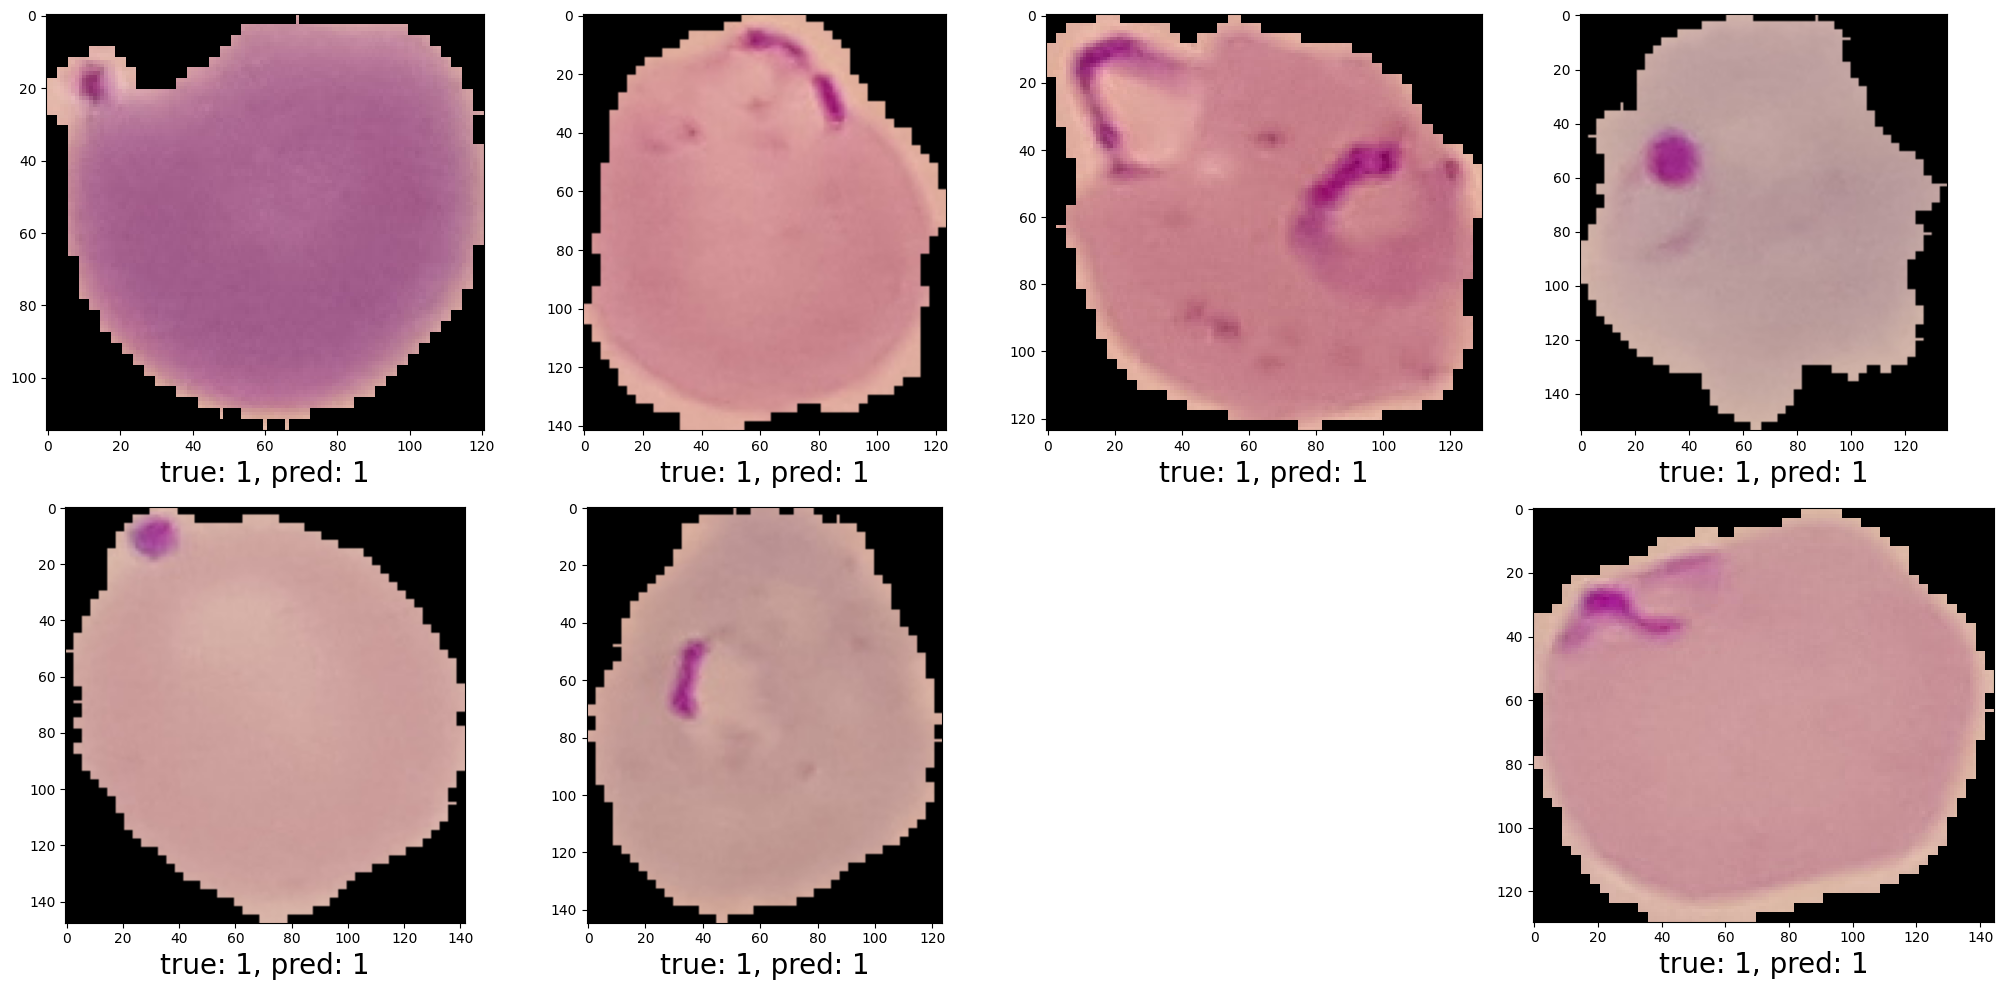

In [ ]:

df_1 = df_correct[df_correct['val_labels'] == 1]

# we see diffrent images each time the code is run.
# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_parasitized + image))

    plt.tight_layout()

    plt.xlabel('true: 1, pred: 1', fontsize=20)


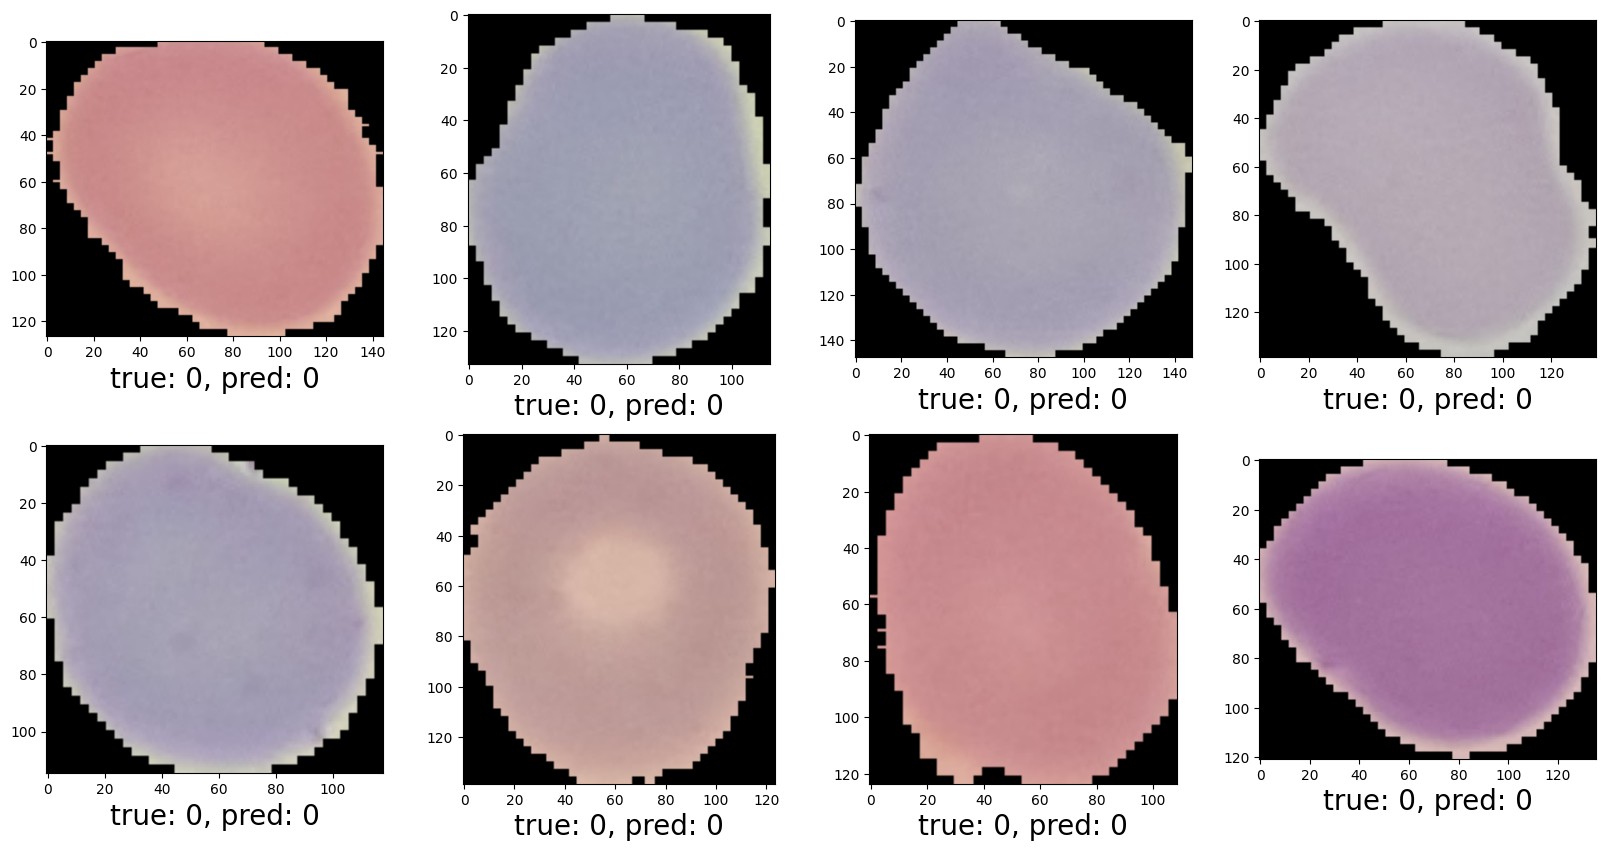

In [ ]:

df_0 = df_correct[df_correct['val_labels'] == 0]

# we see diffrent images each time the code is run.
# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_uninfected + image))

    plt.xlabel('true: 0, pred: 0', fontsize=20)

**Analyze the wrong predictions**

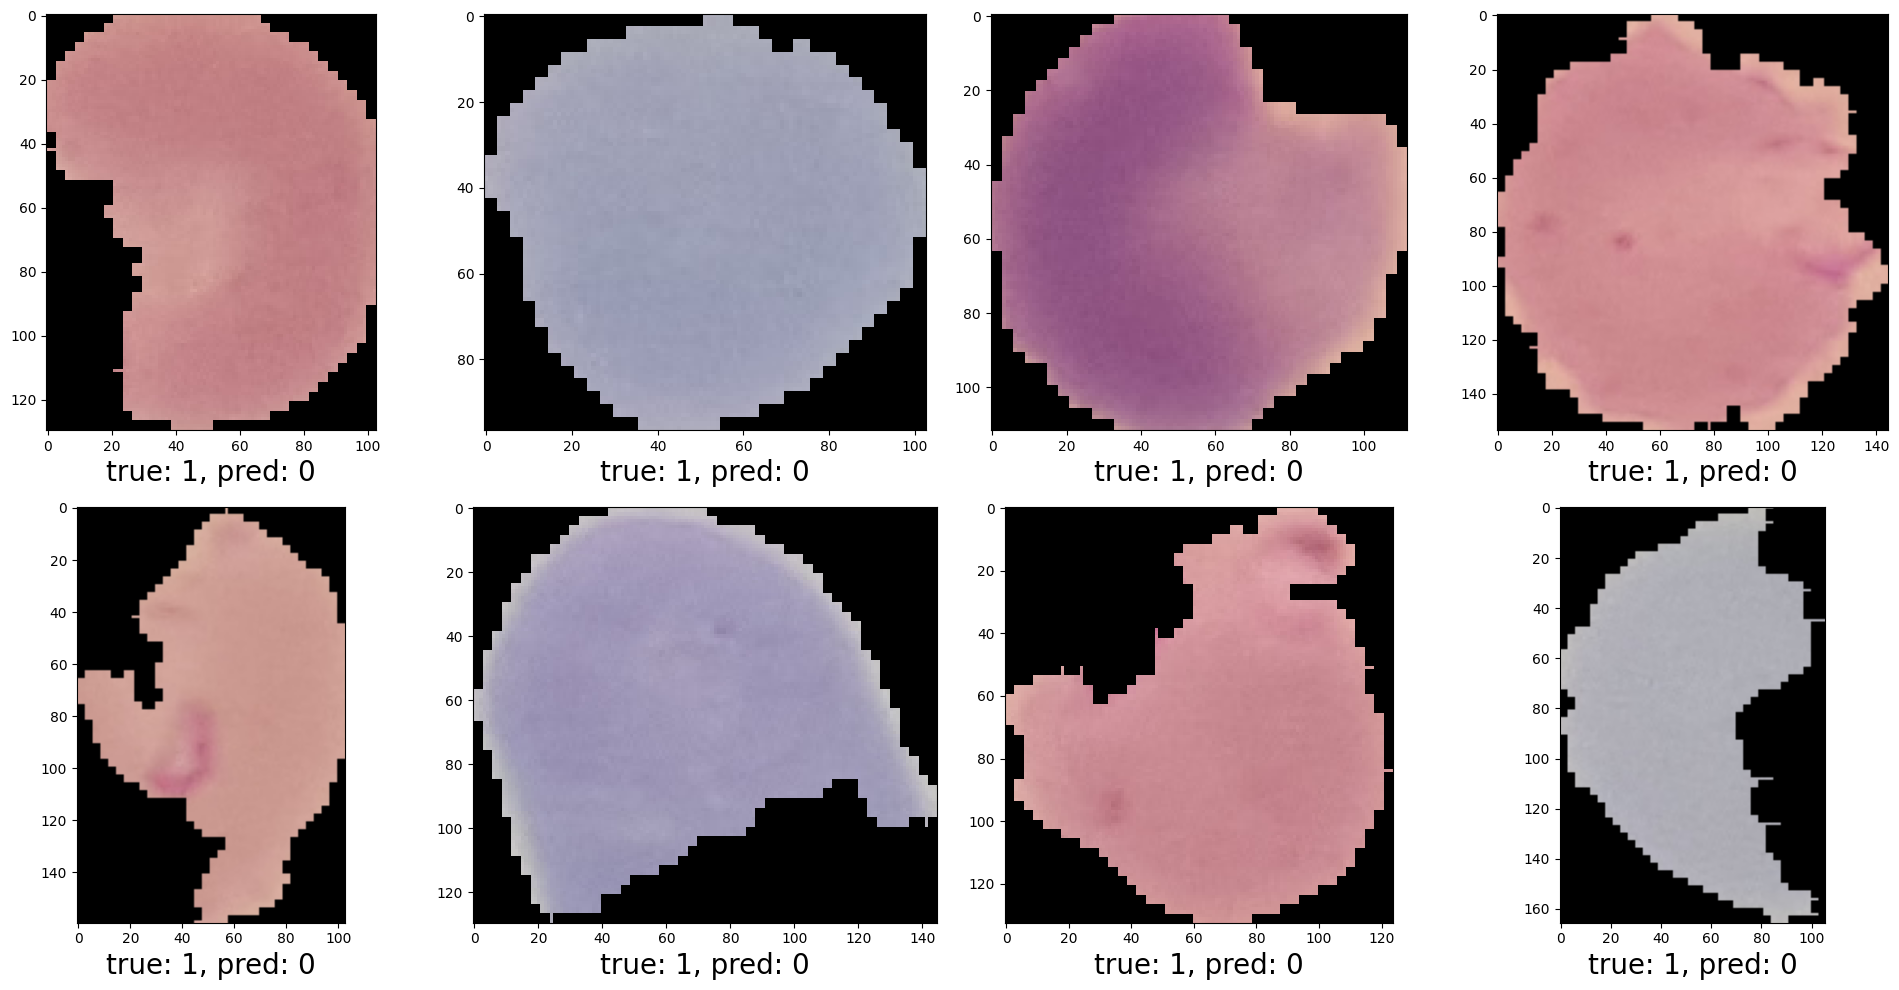

In [ ]:

df_1 = df_wrong[df_wrong['val_labels'] == 1]


# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_parasitized + image))

    plt.tight_layout()

    plt.xlabel('true: 1, pred: 0', fontsize=20)

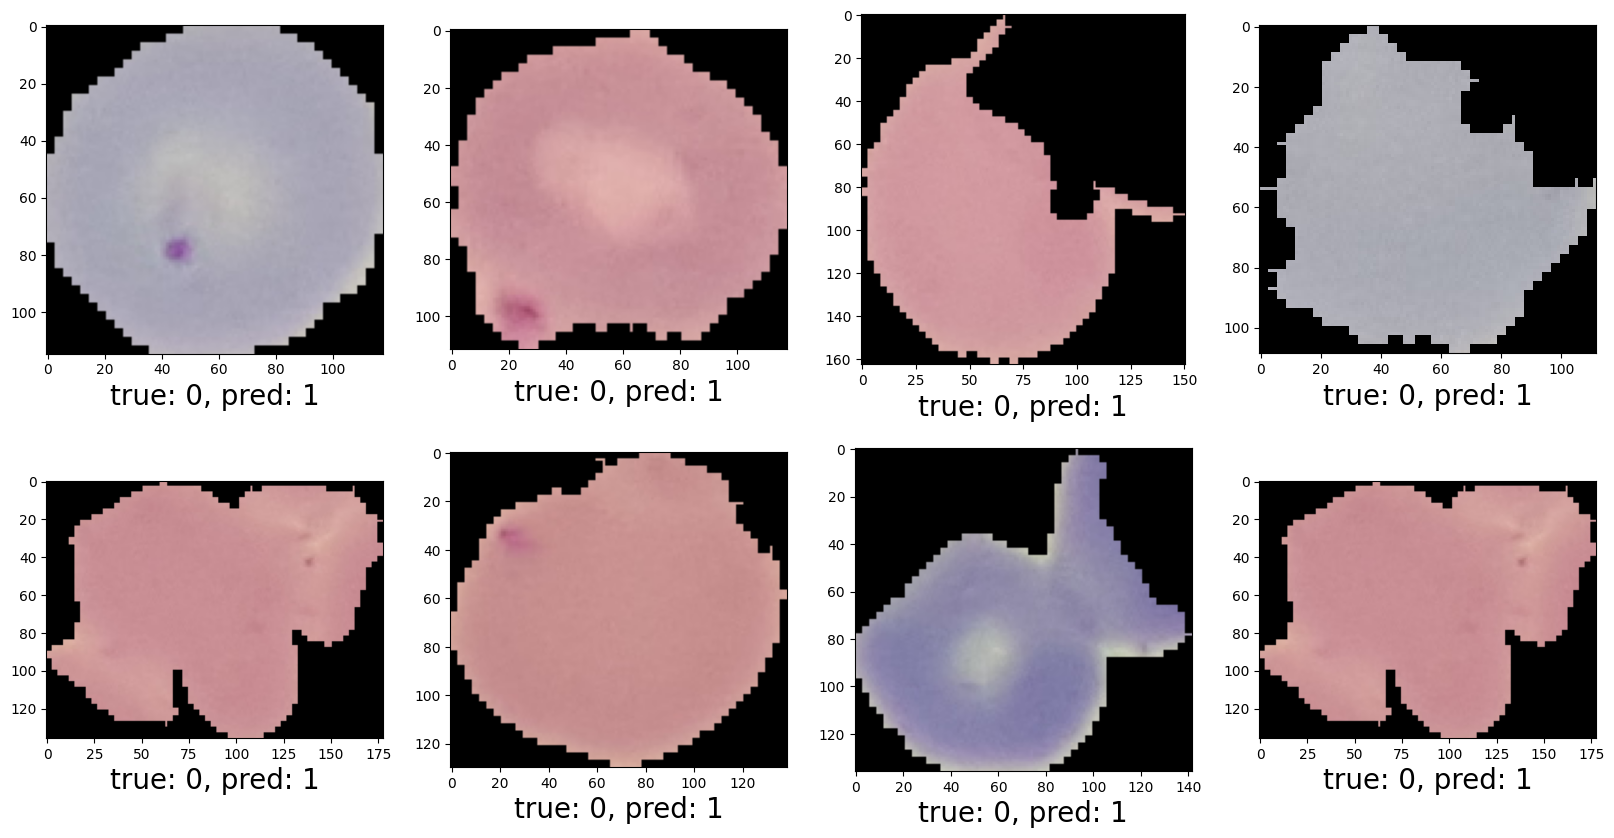

In [ ]:
#
df_0 = df_wrong[df_wrong['val_labels'] == 0]

# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):

    plt.subplot(2,4,i)

    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]

    # display the image
    plt.imshow(plt.imread(path_uninfected + image))

    plt.xlabel('true: 0, pred: 1', fontsize=20)

## **Convert the final model from Keras to Tensorflow.js**

In [ ]:
# Python

import tensorflowjs as tfjs

In [ ]:
!tensorflowjs_converter --input_format keras Malaria_CNN.h5 tfjs/model


2023-05-23 13:01:06.486065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# check that the tfjs files exist
import os
os.listdir('tfjs/model')

['group1-shard3of3.bin',
 'group1-shard2of3.bin',
 'group1-shard1of3.bin',
 'model.json']